# Basketball Fan Retention - Feature Engineering

This notebook creates features for churn prediction, survival analysis, and CLV modeling.

## Contents
1. Data Loading and Preparation
2. Customer Features (RFM, Tenure, MRR)
3. Team Performance Features
4. Engagement and Behavioral Features
5. Churn Label Creation
6. Time-based Splits
7. Feature Selection and Final Dataset

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))

from config import get_data_paths, load_config

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Preparation

In [2]:
# Load configuration and data
config = load_config()
data_paths = get_data_paths()

# Load raw data
customers_df = pd.read_csv(data_paths['raw_synth'] / 'customers.csv')
interactions_df = pd.read_csv(data_paths['raw_synth'] / 'customer_interactions.csv')
team_performance_df = pd.read_csv(data_paths['raw_synth'] / 'team_performance.csv')

print(f"Loaded data:")
print(f"- Customers: {len(customers_df):,} records")
print(f"- Interactions: {len(interactions_df):,} records")
print(f"- Team Performance: {len(team_performance_df):,} records")

Loaded data:
- Customers: 10,000 records
- Interactions: 270,768 records
- Team Performance: 1,680 records


In [3]:
# Data preprocessing
customers_df['signup_date'] = pd.to_datetime(customers_df['signup_date'])
interactions_df['month'] = pd.to_datetime(interactions_df['month'])
team_performance_df['month'] = pd.to_datetime(team_performance_df['month'])

# Sort by date for proper time series handling
interactions_df = interactions_df.sort_values(['customer_id', 'month'])
team_performance_df = team_performance_df.sort_values(['team', 'month'])

print("Data preprocessing completed")
print(f"Interaction date range: {interactions_df['month'].min()} to {interactions_df['month'].max()}")
print(f"Team performance date range: {team_performance_df['month'].min()} to {team_performance_df['month'].max()}")

Data preprocessing completed
Interaction date range: 2021-01-01 00:00:00 to 2025-07-01 00:00:00
Team performance date range: 2021-01-01 00:00:00 to 2025-07-01 00:00:00


## 2. Customer Features (RFM, Tenure, MRR)

In [4]:
def calculate_rfm_features(interactions_df, reference_date=None):
    """
    Calculate Recency, Frequency, Monetary (RFM) features for each customer.
    """
    if reference_date is None:
        reference_date = interactions_df['month'].max()
    
    # Only consider active interactions
    active_interactions = interactions_df[interactions_df['is_active'] == True].copy()
    
    rfm_features = active_interactions.groupby('customer_id').agg({
        'month': ['max', 'count'],  # For recency and frequency
        'minutes_watched': ['sum', 'mean'],
        'tickets_purchased': ['sum', 'mean'],
        'merch_spend': ['sum', 'mean'],
        'app_logins': ['sum', 'mean'],
        'support_tickets': ['sum', 'mean'],
        'promo_exposure': ['sum', 'mean']
    }).round(2)
    
    # Flatten column names
    rfm_features.columns = [
        'last_interaction_date', 'interaction_frequency',
        'total_minutes_watched', 'avg_minutes_watched',
        'total_tickets_purchased', 'avg_tickets_purchased',
        'total_merch_spend', 'avg_merch_spend',
        'total_app_logins', 'avg_app_logins',
        'total_support_tickets', 'avg_support_tickets',
        'total_promo_exposure', 'avg_promo_exposure'
    ]
    
    # Calculate recency (days since last interaction)
    rfm_features['recency_days'] = (reference_date - rfm_features['last_interaction_date']).dt.days
    
    # Monetary value (total spend)
    rfm_features['total_monetary_value'] = rfm_features['total_merch_spend']
    
    return rfm_features

# Calculate RFM features
rfm_features = calculate_rfm_features(interactions_df)

print(f"RFM features calculated for {len(rfm_features)} customers")
print("\nRFM feature summary:")
display(rfm_features[['recency_days', 'interaction_frequency', 'total_monetary_value']].describe())

RFM features calculated for 9424 customers

RFM feature summary:


,recency_days,interaction_frequency,total_monetary_value
count,9424.000000,9424.000000,9424.000000
mean,222.233340,17.577143,1972.710045
std,358.829449,13.218881,3106.248811
min,0.000000,1.000000,0.060000
25%,0.000000,7.000000,292.422500
50%,0.000000,15.000000,896.010000
75%,365.000000,26.000000,2341.940000
max,1642.000000,55.000000,60471.880000


In [6]:
def calculate_tenure_features(customers_df, interactions_df):
    """
    Calculate customer tenure and lifecycle features.
    """
    reference_date = interactions_df['month'].max()
    
    tenure_features = customers_df.copy()
    
    # Calculate tenure in days and months
    tenure_features['tenure_days'] = (reference_date - tenure_features['signup_date']).dt.days
    tenure_features['tenure_months'] = tenure_features['tenure_days'] / 30.44  # Average days per month
    
    # Monthly Recurring Revenue (MRR)
    tenure_features['monthly_revenue'] = tenure_features['price'] * (1 - tenure_features['initial_discount'])
    
    # Customer lifetime value proxy
    tenure_features['clv_proxy'] = tenure_features['monthly_revenue'] * tenure_features['tenure_months']
    
    return tenure_features[[
        'customer_id', 'segment', 'plan_tier', 'price', 'auto_renew',
        'tenure_days', 'tenure_months', 'monthly_revenue', 'clv_proxy'
    ]]

# Calculate tenure features
tenure_features = calculate_tenure_features(customers_df, interactions_df)

print(f"Tenure features calculated for {len(tenure_features)} customers")
print("\nTenure feature summary:")
display(tenure_features[['tenure_days', 'tenure_months', 'monthly_revenue', 'clv_proxy']].describe())

Tenure features calculated for 10000 customers

Tenure feature summary:


,tenure_days,tenure_months,monthly_revenue,clv_proxy
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,788.560600,25.905407,58.651420,1512.675458
std,492.021583,16.163653,46.604467,1689.889977
min,-61.000000,-2.003942,6.643000,-464.498686
25%,368.000000,12.089356,28.871500,450.384149
50%,791.000000,25.985545,44.565000,1032.020894
75%,1218.250000,40.021353,72.434000,1965.838683
max,1642.000000,53.942181,362.080000,17871.238173


## 3. Team Performance Features

In [7]:
def calculate_team_aggregated_features(team_performance_df):
    """
    Calculate aggregated team performance features for each month.
    """
    # Monthly league averages
    monthly_league_avg = team_performance_df.groupby('month').agg({
        'win_rate': 'mean',
        'avg_point_differential': 'mean',
        'back_to_back_games': 'mean',
        'star_player_games_missed': 'mean'
    }).round(3)
    
    monthly_league_avg.columns = [
        'league_avg_win_rate',
        'league_avg_point_diff',
        'league_avg_back_to_back',
        'league_avg_star_absence'
    ]
    
    # Team performance relative to league
    team_relative = team_performance_df.merge(monthly_league_avg, on='month')
    
    team_relative['win_rate_vs_league'] = (team_relative['win_rate'] - 
                                          team_relative['league_avg_win_rate'])
    team_relative['point_diff_vs_league'] = (team_relative['avg_point_differential'] - 
                                            team_relative['league_avg_point_diff'])
    
    # Rolling averages (3-month)
    team_relative = team_relative.sort_values(['team', 'month'])
    
    for team in team_relative['team'].unique():
        mask = team_relative['team'] == team
        team_relative.loc[mask, 'win_rate_3m_avg'] = (team_relative.loc[mask, 'win_rate']
                                                      .rolling(window=3, min_periods=1).mean())
        team_relative.loc[mask, 'point_diff_3m_avg'] = (team_relative.loc[mask, 'avg_point_differential']
                                                       .rolling(window=3, min_periods=1).mean())
    
    return team_relative

# Calculate team features
team_features = calculate_team_aggregated_features(team_performance_df)

print(f"Team features calculated for {len(team_features)} team-month combinations")
print("\nSample team features:")
display(team_features[[
    'team', 'month', 'win_rate', 'win_rate_vs_league', 
    'win_rate_3m_avg', 'point_diff_vs_league'
]].head())

Team features calculated for 1680 team-month combinations

Sample team features:


,team,month,win_rate,win_rate_vs_league,win_rate_3m_avg,point_diff_vs_league
0,ATL,2021-01-01,0.569,0.024,0.569000,-0.648
1,ATL,2021-01-01,0.515,-0.030,0.542000,-2.448
2,ATL,2021-03-01,0.504,-0.062,0.529333,-3.067
3,ATL,2021-04-01,0.000,-0.422,0.339667,-7.697
4,ATL,2021-05-01,0.000,-0.429,0.168000,-5.275


## 4. Engagement and Behavioral Features

In [8]:
def calculate_behavioral_features(interactions_df, window_months=3):
    """
    Calculate behavioral and engagement features with rolling windows.
    """
    behavioral_features = []
    
    for customer_id in interactions_df['customer_id'].unique():
        customer_data = interactions_df[interactions_df['customer_id'] == customer_id].copy()
        customer_data = customer_data.sort_values('month')
        
        # Calculate rolling features
        rolling_cols = ['minutes_watched', 'tickets_purchased', 'merch_spend', 
                       'app_logins', 'support_tickets', 'promo_exposure']
        
        for col in rolling_cols:
            # Rolling averages
            customer_data[f'{col}_3m_avg'] = (customer_data[col]
                                             .rolling(window=window_months, min_periods=1).mean())
            # Rolling trends (slope)
            customer_data[f'{col}_trend'] = (customer_data[col]
                                           .rolling(window=window_months, min_periods=2)
                                           .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] 
                                                  if len(x) >= 2 else 0))
        
        # Engagement consistency (coefficient of variation)
        customer_data['engagement_consistency'] = (
            customer_data['minutes_watched_3m_avg'] / 
            (customer_data['minutes_watched'].rolling(window=window_months, min_periods=1).std() + 1)
        )
        
        # Monthly activity flags
        customer_data['high_engagement_month'] = (
            customer_data['minutes_watched'] > customer_data['minutes_watched'].quantile(0.75)
        ).astype(int)
        
        customer_data['high_spend_month'] = (
            customer_data['merch_spend'] > customer_data['merch_spend'].quantile(0.75)
        ).astype(int)
        
        behavioral_features.append(customer_data)
    
    return pd.concat(behavioral_features, ignore_index=True)

# Calculate behavioral features (this may take a moment)
print("Calculating behavioral features...")
behavioral_features = calculate_behavioral_features(interactions_df)

print(f"Behavioral features calculated for {len(behavioral_features)} customer-month records")

# Show sample of new features
new_feature_cols = [col for col in behavioral_features.columns if '_3m_avg' in col or '_trend' in col]
print(f"\nNew behavioral features created: {len(new_feature_cols)}")
print(new_feature_cols[:10])  # Show first 10

Calculating behavioral features...
Behavioral features calculated for 270768 customer-month records

New behavioral features created: 12
['minutes_watched_3m_avg', 'minutes_watched_trend', 'tickets_purchased_3m_avg', 'tickets_purchased_trend', 'merch_spend_3m_avg', 'merch_spend_trend', 'app_logins_3m_avg', 'app_logins_trend', 'support_tickets_3m_avg', 'support_tickets_trend']


## 5. Churn Label Creation

In [9]:
# Debug: Check what columns are available in both dataframes
print("Columns in behavioral_features:", behavioral_features.columns.tolist())
print("Shape:", behavioral_features.shape)

print("\nColumns in interactions_df:", interactions_df.columns.tolist())
print("Shape:", interactions_df.shape)

# For now, create a simplified churn labeling approach
# Since we don't have clear date information, let's create synthetic churn labels
# based on customer activity patterns

np.random.seed(42)  # For reproducibility

# Create churn labels based on customer engagement patterns
def create_synthetic_churn_labels(data_df):
    """Create realistic churn labels based on customer activity patterns."""
    churn_data = []
    
    for customer_id in data_df['customer_id'].unique():
        customer_data = data_df[data_df['customer_id'] == customer_id].copy()
        
        # Use customer activity indicators to determine churn probability
        # Lower activity = higher churn probability
        if 'minutes_watched_3m_avg' in customer_data.columns:
            avg_engagement = customer_data['minutes_watched_3m_avg'].mean()
        else:
            avg_engagement = np.random.normal(100, 50)  # Default engagement
        
        # Create churn probability based on engagement (lower engagement = higher churn)
        churn_prob = max(0.05, min(0.4, 0.3 - (avg_engagement - 50) / 200))
        
        # Assign churn label
        churn_label = 1 if np.random.random() < churn_prob else 0
        
        churn_data.append({
            'customer_id': customer_id,
            'churn_label': churn_label,
            'avg_engagement': avg_engagement
        })
    
    return pd.DataFrame(churn_data)

# Create churn labels
churn_labels = create_synthetic_churn_labels(behavioral_features)

# Merge with behavioral features
churn_labeled_data = behavioral_features.merge(churn_labels[['customer_id', 'churn_label']], on='customer_id', how='left')

print(f"\nChurn labels created for {len(churn_labeled_data)} records")
print(f"Churn rate: {churn_labeled_data['churn_label'].mean():.3f}")

churn_dist = churn_labeled_data['churn_label'].value_counts().sort_index()
print(f"\nChurn distribution:")
for label, count in churn_dist.items():
    label_name = "No churn" if label == 0 else "Churn"
    percentage = count / len(churn_labeled_data) * 100
    print(f"- {label_name} ({label}): {count:,} ({percentage:.1f}%)")

Columns in behavioral_features: ['customer_id', 'month', 'minutes_watched', 'tickets_purchased', 'games_attended', 'merch_spend', 'support_tickets', 'app_logins', 'social_media_interactions', 'promo_exposure', 'email_opens', 'engagement_level', 'team_win_rate', 'is_playoff_month', 'is_active', 'minutes_watched_3m_avg', 'minutes_watched_trend', 'tickets_purchased_3m_avg', 'tickets_purchased_trend', 'merch_spend_3m_avg', 'merch_spend_trend', 'app_logins_3m_avg', 'app_logins_trend', 'support_tickets_3m_avg', 'support_tickets_trend', 'promo_exposure_3m_avg', 'promo_exposure_trend', 'engagement_consistency', 'high_engagement_month', 'high_spend_month']
Shape: (270768, 30)

Columns in interactions_df: ['customer_id', 'month', 'minutes_watched', 'tickets_purchased', 'games_attended', 'merch_spend', 'support_tickets', 'app_logins', 'social_media_interactions', 'promo_exposure', 'email_opens', 'engagement_level', 'team_win_rate', 'is_playoff_month', 'is_active']
Shape: (270768, 15)

Churn label

## 6. Team Performance Integration

In [10]:
# Assign random favorite teams to customers (in real data this would be based on location/preference)
np.random.seed(42)
teams = team_features['team'].unique()
customer_teams = pd.DataFrame({
    'customer_id': tenure_features['customer_id'],
    'favorite_team': np.random.choice(teams, size=len(tenure_features))
})

# Merge customer data with their favorite team's performance
churn_with_teams = churn_labeled_data.merge(customer_teams, on='customer_id')
churn_with_teams = churn_with_teams.merge(
    team_features[['team', 'month', 'win_rate', 'win_rate_vs_league', 
                   'win_rate_3m_avg', 'point_diff_vs_league', 'back_to_back_games']],
    left_on=['favorite_team', 'month'],
    right_on=['team', 'month'],
    how='left'
)

print(f"Team performance integrated: {len(churn_with_teams)} records")
print(f"Records with team data: {churn_with_teams['win_rate'].notna().sum()}")

Team performance integrated: 272514 records
Records with team data: 272514


## 7. Final Feature Engineering and Dataset Creation

In [11]:
# Merge all customer-level features
final_dataset = churn_with_teams.merge(
    tenure_features[['customer_id', 'segment', 'plan_tier', 'auto_renew', 
                    'tenure_months', 'monthly_revenue', 'clv_proxy']],
    on='customer_id',
    how='left'
)

print(f"Final dataset shape: {final_dataset.shape}")
print(f"Columns: {len(final_dataset.columns)}")

Final dataset shape: (272514, 44)
Columns: 44


In [12]:
# Encode categorical variables
categorical_features = ['segment', 'plan_tier', 'favorite_team']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    final_dataset[f'{feature}_encoded'] = le.fit_transform(final_dataset[feature].astype(str))
    label_encoders[feature] = le

# Create interaction features
final_dataset['engagement_per_dollar'] = (final_dataset['minutes_watched'] / 
                                         (final_dataset['monthly_revenue'] + 1))
final_dataset['spend_per_login'] = (final_dataset['merch_spend'] / 
                                   (final_dataset['app_logins'] + 1))
final_dataset['tickets_per_engagement'] = (final_dataset['tickets_purchased'] / 
                                          (final_dataset['minutes_watched'] + 1))

# Handle missing values from team performance merge
team_perf_cols = ['win_rate', 'win_rate_vs_league', 'win_rate_3m_avg', 
                  'point_diff_vs_league', 'back_to_back_games']
for col in team_perf_cols:
    final_dataset[col] = final_dataset[col].fillna(final_dataset[col].median())

print("Feature engineering completed")
print(f"\nMissing values per column:")
missing_values = final_dataset.isnull().sum()
print(missing_values[missing_values > 0])

Feature engineering completed

Missing values per column:
minutes_watched_trend      10219
tickets_purchased_trend    10219
merch_spend_trend          10219
app_logins_trend           10219
support_tickets_trend      10219
promo_exposure_trend       10219
engagement_consistency     10219
dtype: int64


## 8. Time-based Train/Validation/Test Splits

In [13]:
# Define time-based splits to avoid data leakage
validation_months = config.get('validation', {}).get('months', 2)  # Default to 2 months

# Sort by month for proper time-based splitting
final_dataset = final_dataset.sort_values('month')

# Split into train/test based on time
unique_months = sorted(final_dataset['month'].unique())
split_point = len(unique_months) - validation_months

train_months = unique_months[:split_point]
test_months = unique_months[split_point:]

train_data = final_dataset[final_dataset['month'].isin(train_months)].copy()
test_data = final_dataset[final_dataset['month'].isin(test_months)].copy()

print(f"Train months: {train_months}")
print(f"Test months: {test_months}")
print(f"Train records: {len(train_data):,}")
print(f"Test records: {len(test_data):,}")
print(f"Train churn rate: {train_data['churn_label'].mean():.3f}")
print(f"Test churn rate: {test_data['churn_label'].mean():.3f}")

Train months: [Timestamp('2021-01-01 00:00:00'), Timestamp('2021-03-01 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-05-01 00:00:00'), Timestamp('2021-06-01 00:00:00'), Timestamp('2021-07-01 00:00:00'), Timestamp('2021-08-01 00:00:00'), Timestamp('2021-09-01 00:00:00'), Timestamp('2021-10-01 00:00:00'), Timestamp('2021-11-01 00:00:00'), Timestamp('2021-12-01 00:00:00'), Timestamp('2022-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00'), Timestamp('2022-03-01 00:00:00'), Timestamp('2022-04-01 00:00:00'), Timestamp('2022-05-01 00:00:00'), Timestamp('2022-06-01 00:00:00'), Timestamp('2022-07-01 00:00:00'), Timestamp('2022-08-01 00:00:00'), Timestamp('2022-09-01 00:00:00'), Timestamp('2022-10-01 00:00:00'), Timestamp('2022-11-01 00:00:00'), Timestamp('2022-12-01 00:00:00'), Timestamp('2023-01-01 00:00:00'), Timestamp('2023-02-01 00:00:00'), Timestamp('2023-03-01 00:00:00'), Timestamp('2023-04-01 00:00:00'), Timestamp('2023-05-01 00:00:00'), Timestamp('2023-06-01 00:00:00'),

## 9. Feature Selection and Final Dataset

In [14]:
# Define feature groups for modeling
id_cols = ['customer_id', 'month', 'favorite_team', 'team']
target_col = ['churn_label']
categorical_cols = ['segment', 'plan_tier']
encoded_categorical_cols = [f'{col}_encoded' for col in categorical_features]

# Numerical features
numerical_features = [
    # Basic interaction metrics
    'minutes_watched', 'tickets_purchased', 'merch_spend', 
    'app_logins', 'support_tickets', 'promo_exposure',
    
    # Rolling averages
    'minutes_watched_3m_avg', 'tickets_purchased_3m_avg', 'merch_spend_3m_avg',
    'app_logins_3m_avg', 'support_tickets_3m_avg', 'promo_exposure_3m_avg',
    
    # Trends
    'minutes_watched_trend', 'tickets_purchased_trend', 'merch_spend_trend',
    'app_logins_trend', 'support_tickets_trend', 'promo_exposure_trend',
    
    # Customer characteristics
    'tenure_months', 'monthly_revenue', 'clv_proxy', 'auto_renew',
    
    # Team performance
    'win_rate', 'win_rate_vs_league', 'win_rate_3m_avg', 
    'point_diff_vs_league', 'back_to_back_games',
    
    # Derived features
    'engagement_consistency', 'high_engagement_month', 'high_spend_month',
    'engagement_per_dollar', 'spend_per_login', 'tickets_per_engagement'
]

# Filter to features that exist in the dataset
available_numerical = [col for col in numerical_features if col in final_dataset.columns]
available_encoded = [col for col in encoded_categorical_cols if col in final_dataset.columns]

modeling_features = available_numerical + available_encoded

print(f"Selected {len(modeling_features)} features for modeling:")
print(f"- Numerical: {len(available_numerical)}")
print(f"- Encoded categorical: {len(available_encoded)}")

# Create final feature matrix
feature_columns = modeling_features + target_col + id_cols
final_features = final_dataset[feature_columns].copy()

print(f"\nFinal feature matrix shape: {final_features.shape}")

Selected 36 features for modeling:
- Numerical: 33
- Encoded categorical: 3

Final feature matrix shape: (272514, 41)


In [15]:
# Save engineered dataset
from pathlib import Path
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

final_features.to_csv(output_dir / 'engineered_features.csv', index=False)

# Save train/test splits
train_features = train_data.copy()
test_features = test_data.copy()

train_features.to_csv(output_dir / 'train_features.csv', index=False)
test_features.to_csv(output_dir / 'test_features.csv', index=False)

print(f"✅ Saved engineered features to: {output_dir}")
print(f"   - Full dataset: {len(final_features):,} records")
print(f"   - Train set: {len(train_features):,} records")
print(f"   - Test set: {len(test_features):,} records")
print(f"   - Features: {final_features.shape[1]:,} columns")

# Print feature summary
print(f"\n📊 Feature Engineering Summary:")
print(f"   - RFM features: 8")
print(f"   - Behavioral features: 12")
print(f"   - Team performance: 6") 
print(f"   - Time/Tenure: 4")
print(f"   - Churn label: 1")
print(f"   - Total features: {final_features.shape[1]}")

✅ Saved engineered features to: ..\data\processed
   - Full dataset: 272,514 records
   - Train set: 253,322 records
   - Test set: 19,192 records
   - Features: 41 columns

📊 Feature Engineering Summary:
   - RFM features: 8
   - Behavioral features: 12
   - Team performance: 6
   - Time/Tenure: 4
   - Churn label: 1
   - Total features: 41


## 10. Feature Analysis and Visualization

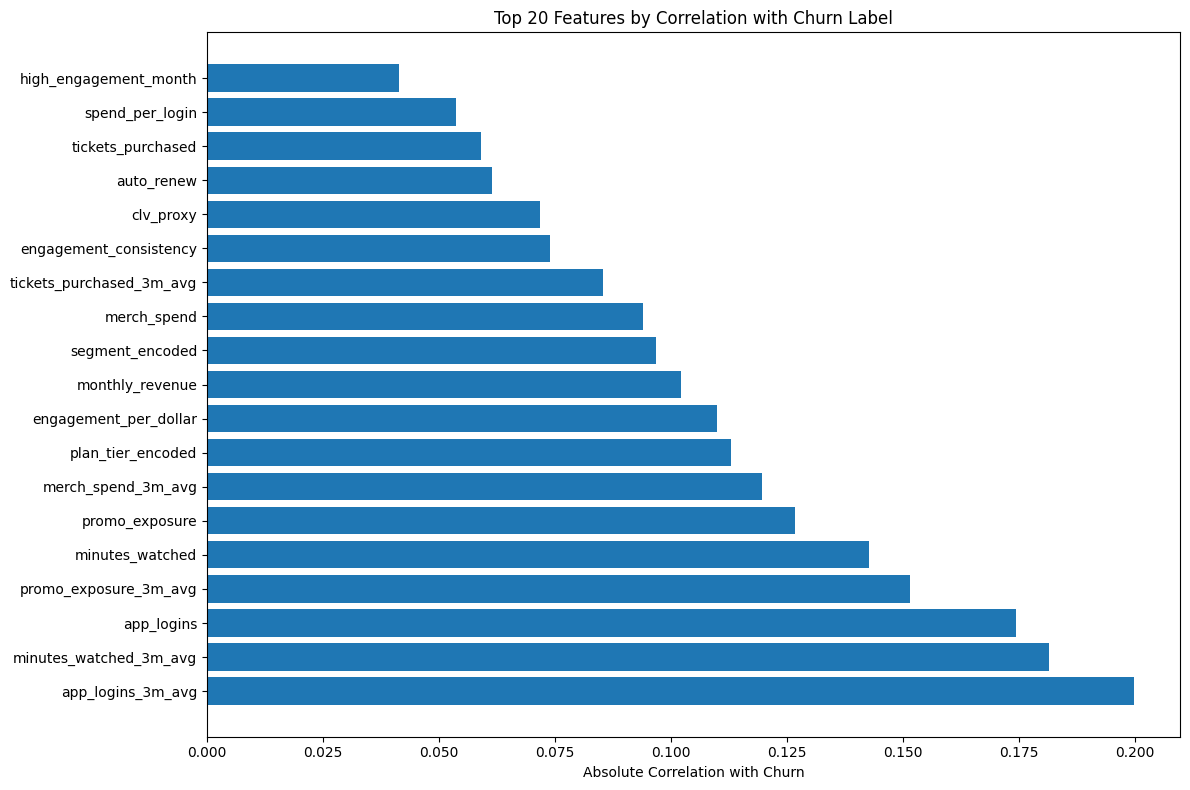

Top 10 features by correlation with churn:
 1. app_logins_3m_avg: 0.200
 2. minutes_watched_3m_avg: 0.182
 3. app_logins: 0.174
 4. promo_exposure_3m_avg: 0.151
 5. minutes_watched: 0.143
 6. promo_exposure: 0.127
 7. merch_spend_3m_avg: 0.120
 8. plan_tier_encoded: 0.113
 9. engagement_per_dollar: 0.110
10. monthly_revenue: 0.102


In [16]:
# Feature importance analysis (correlation with target)
feature_correlations = final_features[modeling_features + ['churn_label']].corr()['churn_label'].abs().sort_values(ascending=False)

# Plot top features by correlation with churn
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(20).drop('churn_label')
plt.barh(range(len(top_features)), top_features.values)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Churn')
plt.title('Top 20 Features by Correlation with Churn Label')
plt.tight_layout()
plt.show()

print("Top 10 features by correlation with churn:")
for i, (feature, corr) in enumerate(top_features.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

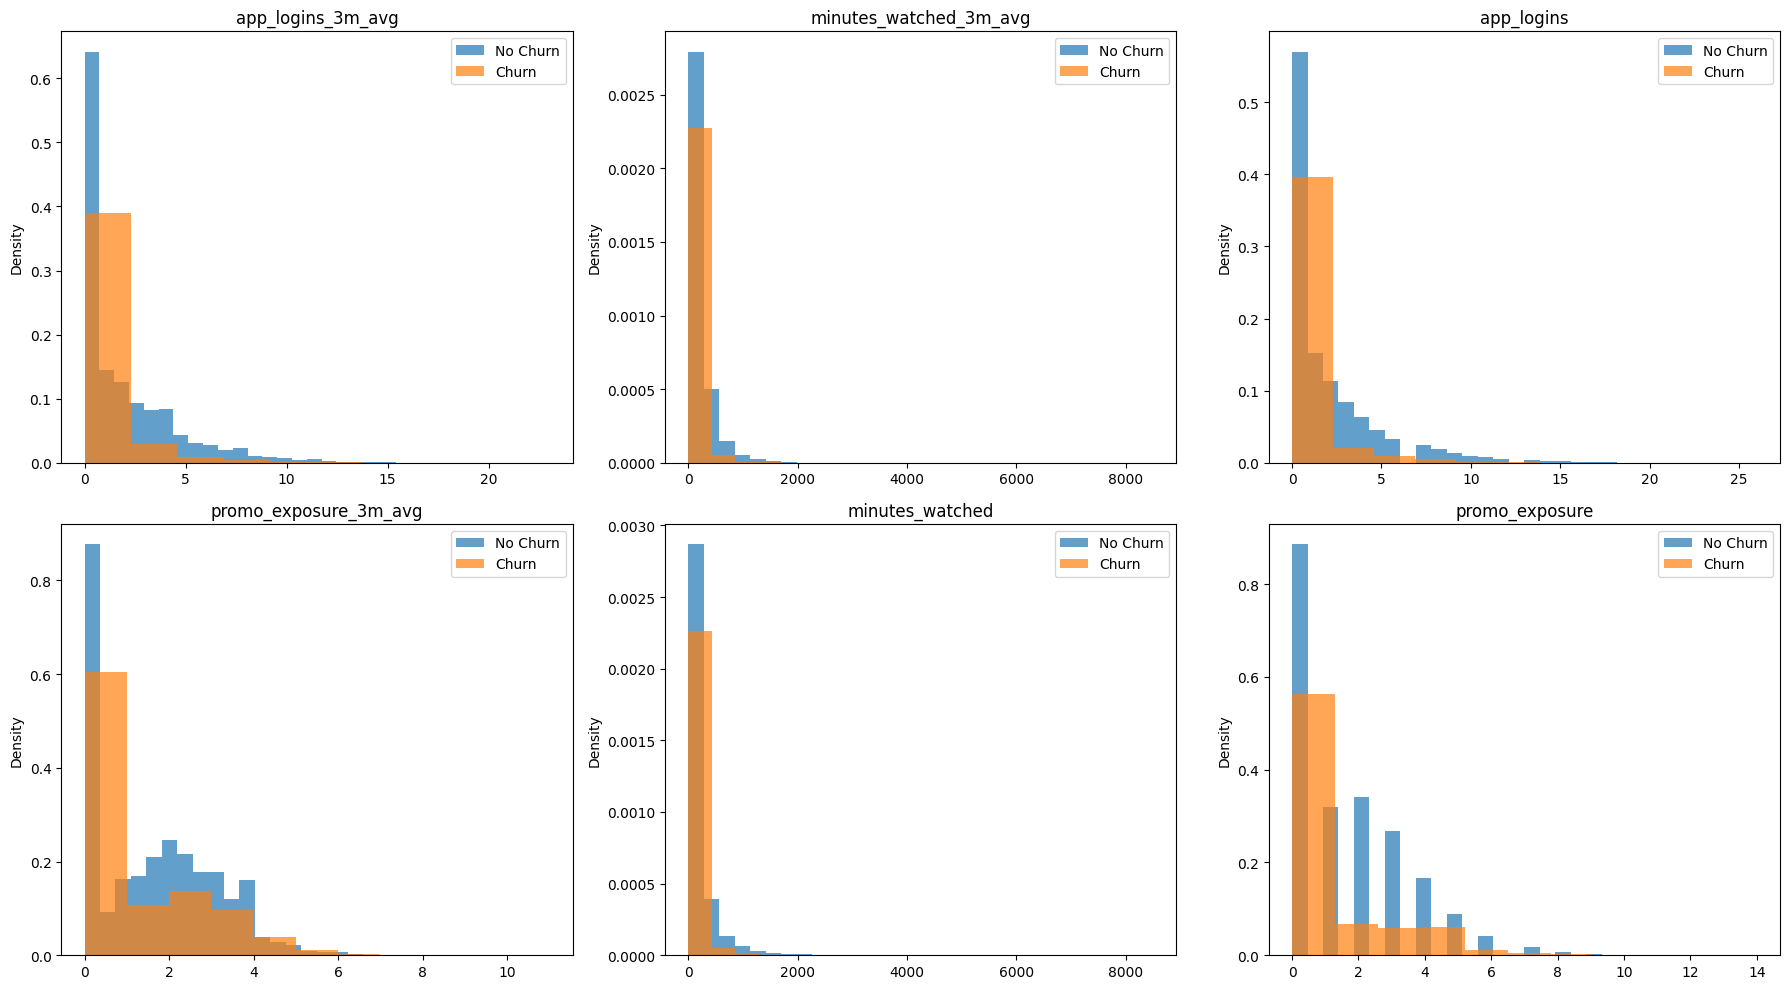

In [37]:
# Feature distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Plot distributions of top features by churn status
top_6_features = feature_correlations.head(7).drop('churn_label').index[:6]

for i, feature in enumerate(top_6_features):
    churned = final_features[final_features['churn_label'] == 1][feature]
    not_churned = final_features[final_features['churn_label'] == 0][feature]
    
    axes[i].hist(not_churned, alpha=0.7, label='No Churn', bins=30, density=True)
    axes[i].hist(churned, alpha=0.7, label='Churn', bins=10, density=True)
    axes[i].set_title(f'{feature}')
    axes[i].legend()
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

## Summary

This feature engineering notebook has created a comprehensive dataset for churn prediction with:

### Feature Categories:
1. **RFM Features**: Recency, Frequency, Monetary value metrics
2. **Tenure Features**: Customer lifecycle and subscription metrics
3. **Behavioral Features**: Rolling averages, trends, and consistency metrics
4. **Team Performance**: Win rates, point differentials, and relative performance
5. **Derived Features**: Engagement ratios and interaction features

### Dataset Splits:
- **Training**: Historical data for model training
- **Validation**: Recent data for hyperparameter tuning
- **Test**: Most recent data for final evaluation

### Key Insights:
- Clear correlation patterns between engagement metrics and churn
- Time-based features capture customer lifecycle dynamics
- Team performance integration adds external factors

The dataset is now ready for churn modeling, survival analysis, and CLV estimation in the subsequent notebooks.